## Steady-state superradiance

Author: Nathan Shammah (nathan.shammah@gmail.com)

We consider a system of $N$ two-level systems (TLSs) with identical frequency $\omega_{0}$, incoherently pumped at a rate $\gamma_\text{P}$ and de-excitating at a collective emission rate $\gamma_\text{CE}$,

\begin{eqnarray}
\dot{\rho} &=& 
-i\lbrack \omega_{0}J_z,\rho \rbrack
+\frac{\gamma_\text {CE}}{2}\mathcal{L}_{J_{-}}[\rho]
+\frac{\gamma_\text{P}}{2}\sum_{n=1}^{N}\mathcal{L}_{J_{+,n}}[\rho]
\end{eqnarray}
This system can sustain superradiant light emission and line narrowing [1-3],  whose peak intensity scales proportionally to $N^2$.

In [2]:
import matplotlib.pyplot as plt
from qutip import *
from qutip.models.piqs import *

## 1) Time evolution

We study the system of Eq. (1) (above) by using the *Permutational Invariant Quantum Solver (PIQS)* to build the Liouvillian of the system. Using QuTiP's $\texttt{mesolve}()$ we can calculate operators expectation values in time as well as higher order correlation functions [4,5]. 

### System properties

In [3]:
N = 10
system = Dicke(N = N)
[jx, jy, jz, jp, jm] = j_algebra(N)
w0 = 1
h0 = w0 * jz
gCE = 1
gP = N * gCE
system.hamiltonian = h0
system.collective_emission = gCE
system.pumping = gP

### Liouvillian and steady state $\rho_\text{ss}$

In [4]:
L = system.liouvillian()
rhoss = steadystate(L)
jpjm_ss = expect(jp*jm, rhoss)

### Time integration for $g^{(2)}(\tau)$ and $\langle J_{+}J_{-}\rangle (t)$
We define the $g^{(2)}(\tau)$ of the system as the two-time correlation function mapping the photonic degrees of freedom onto the TLS collective operators

\begin{eqnarray*}
g^{(2)}(\tau) = \frac{\langle: J^\dagger(\tau) a^\dagger(0) a(\tau) a(0) :\rangle}{|\langle: a^\dagger(0) a(0) :\rangle|^2}= \frac{\langle: J_{+}(\tau) J_{+}(0) J_{-}(\tau) J_{-}(0) :\rangle}{|\langle J_{+}(0) J_{-}(0) \rangle|^2}
\end{eqnarray*}

In [5]:
# time evolution parameters
nt = 1000
td = np.log(N)/(N*gCE)
tmax = 5 * td
t = np.linspace(0, tmax, nt)
# initial state
rho0= dicke(N, N/2, -N/2)
# calculate g2(tau)
A = jp*jm
rhoA = jm*rhoss*jp
#g2(tau)
result1 = mesolve(L, rhoA, t, [], e_ops = [A], options = Options(store_states=True))
g2t = result1.expect[0]
#rho(t)
result2 = mesolve(L, rho0, t, [], e_ops = A, options = Options(store_states=True))
rhot = result2.states
jpjmt = result2.expect[0]

### Visualization

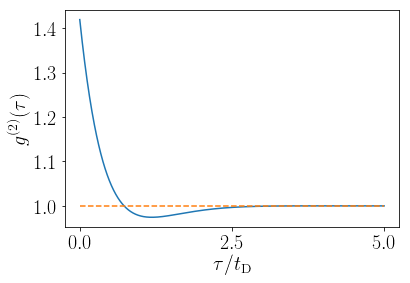

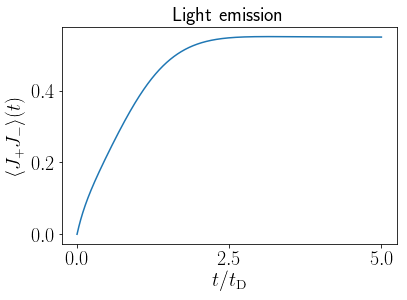

In [6]:
j2max = (0.5 * N + 1) * (0.5 * N)

plt.rc('text', usetex = True)
label_size = 20
plt.rc('xtick', labelsize=label_size) 
plt.rc('ytick', labelsize=label_size)

fig1 = plt.figure()
plt.plot(t/td, g2t/jpjm_ss**2, '-')
plt.plot(t/td, 1+0*g2t, '--')
plt.xlabel(r'$\tau/t_\mathrm{D}$', fontsize = label_size)
plt.ylabel(r'$g^{(2)}(\tau)$', fontsize = label_size)
plt.xticks([0,(tmax/2)/td,tmax/td])
plt.show()
plt.close()


fig2 = plt.figure()
plt.plot(t/td, jpjmt/j2max, '-')
plt.xlabel(r'$t/t_\mathrm{D}$', fontsize = label_size)
plt.ylabel(r'$\langle J_{+}J_{-}\rangle (t)$', fontsize = label_size)
plt.xticks([0,(tmax/2)/td,tmax/td])
plt.title(r'Light emission', fontsize = label_size)
plt.show()
plt.close()

## 2) Maximum of light emission as a function of  $\frac{\gamma_\text{P}}{N\gamma_\text{CE}}$

We perform a study of the scaling of the steady state light emission of the system as a function of the pumping rate, normalized by the number of TLSs and the collective emission rate. The results show an optimal point for $\frac{\gamma_\text{P}}{N\gamma_\text{CE}}\simeq 1$. 

In [7]:
# Cycle on Coefficients
gCE = 1
gP0 = 1
gP_min_exp = -20
gP_max_exp = 20
gP_stepsize = 0.5
gP_list = np.arange(gP_min_exp, gP_max_exp+1, gP_stepsize)*0.1
gP_list_log = 10**(gP_list)

jpjmss_max_list = []
for i in gP_list_log:
    gP = i*gP0
    system = Dicke(hamiltonian = jz, N = N, pumping = gP, collective_emission = gCE)
    liouv = system.liouvillian()
    #steadystate
    rho_ss = steadystate(liouv)
    jpjm_ss = expect(jp*jm, rho_ss)
    jpjmss_max_list.append(jpjm_ss)

#### Visualization

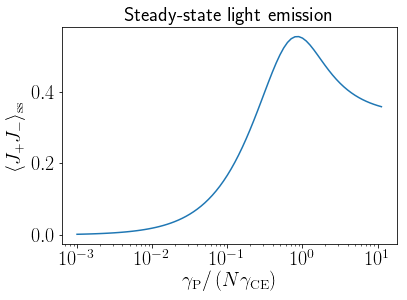

In [8]:
intensity_max = float(N)*gCE/2*(float(N)*gCE/2+1)
normalized_intensity = np.array(jpjmss_max_list)/intensity_max
plt.semilogx(gP_list_log/(gCE*N), normalized_intensity, '-')
label_size = 20
plt.xlabel(r'${\gamma_\mathrm{P}}/\left({N\gamma_\mathrm{CE}}\right)$', fontsize = label_size)
plt.ylabel(r'$\langle J_{+}J_{-}\rangle_\mathrm{ss}$', fontsize = label_size)
plt.title(r'Steady-state light emission', fontsize = label_size)
plt.show()
plt.close()

#### References

[1] D. Meiser and M.J. Holland, *Phys. Rev. A* **81**, 033847 (2010)

[2] D. Meiser and M.J. Holland, *Phys. Rev. A* **81**, 063827 (2010)

[3] J.G. Bohnet *et al.* *Nature* **484**, 78 (2012)

[4] J.R. Johansson, P.D. Nation, and F. Nori, *Comp. Phys. Comm.* **183**, 1760 (2012) http://qutip.org

In [9]:
qutip.about()


QuTiP: Quantum Toolbox in Python
Copyright (c) 2011 and later.
A. J. Pitchford, P. D. Nation, R. J. Johansson, A. Grimsmo, and C. Granade

QuTiP Version:      4.3.0.dev0+cdc2204a
Numpy Version:      1.13.3
Scipy Version:      1.0.0
Cython Version:     0.27.3
Matplotlib Version: 2.1.1
Python Version:     3.6.3
Number of CPUs:     2
BLAS Info:          INTEL MKL
OPENMP Installed:   False
INTEL MKL Ext:      True
Platform Info:      Darwin (x86_64)
Installation path:  /Users/nathanshammah/Dropbox/GitHub/qutip/qutip
Please cite QuTiP in your publication.
For your convenience a bibtex file can be easily generated using `qutip.about.cite()`
